# Momentum Budget closure in MOM6
*Contributors:* [Hemant Khatri](https://github.com/hmkhatri), [Stephen Griffies](https://github.com/StephenGriffies)

Here, we outline the terms required to close the momentum budget in MOM6. Similar to tracer budgets, the momentum budget closes on the native grid as well as on the remapped diagnostic grid ($z^*$ and $\rho_2$).

## Governing equations

As discussed in Appendix A in [Adcroft et al. 2019]( https://doi.org/10.1029/2019MS001726), MOM6 discretizes the vector-invariant velocity equation. This equation takes on the following continuous space-time form using a generalized vertical coordinate $s = s(x,y,z,t)$

\begin{equation}
\left[ \frac{\partial \mathbf{u}}{\partial t} \right]_{s} = - \left[ \frac{f + \zeta}{h} \right] \hat{\mathbf{z}} \wedge (h \, \mathbf{u}) - w^{(\dot{s})} \, \frac{\partial \mathbf{u}}{\partial z} -\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right] - \nabla_{s} K + \boldsymbol{F}^{{\text{horz frict}}} + \boldsymbol{F}^{{\text{vert frict}}} + \rho^{-1} \, \boldsymbol{\tau}^{\text{bound}} 
\end{equation}

where we have 

\begin{eqnarray}
\mathbf{v} = \mathbf{u} + \mathbf{\hat{z}} \, w
= \mathbf{\hat{x}} \, u  +  \mathbf{\hat{y}} \, v + \mathbf{\hat{z}} \, w & & \qquad \mbox{velocity} \\
\nabla_{s} = \mathbf{\hat{x}} \left[\frac{\partial}{\partial x} \right]_{s} +
\mathbf{\hat{y}} \left[\frac{\partial}{\partial y} \right]_{s}
& & \qquad \mbox{horizontal gradient on s-surface} \\
w^{(\dot{s})} = \frac{\partial z}{\partial s} \, \frac{\mathrm{D}s}{\mathrm{D}t}
& & \qquad \mbox{dia-surface velocity used for remapping} \\
\zeta = \left[\frac{\partial v}{\partial x} \right]_{s} 
        -\left[\frac{\partial u}{\partial y} \right]_{s} 
& & \qquad \mbox{s-coordinate vertical vorticity} \\
\Phi = g \, z & & \qquad 
\mbox{geopotential (more complex when have tides)} \\
-\rho^{-1} \, \nabla_{z}p  = 
-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right] & & \qquad \mbox{horizontal pressure acceleration} \\
K = \frac{u^{2} + v^{2}}{2}  & & \qquad \mbox{horizontal kinetic energy per unit mass} \\
\boldsymbol{F}^{{\text{horz frict}}} 
& & \qquad \mbox{horiz friction from horz shear (Laplacian or biharmonic)}\\
\boldsymbol{F}^{{\text{vert frict}}}
& & \qquad  \mbox{vert friction from vertical shear (Laplacian)}\\
\rho^{-1} \, \boldsymbol{\tau}^{{\text{bound}}}
& & \qquad  \mbox{boundary frictional acceleration (wind, bottom drag, etc.)}
\end{eqnarray}

The hydrostatic pressure, $p$, arises from the weight per horizontal area above a point in the fluid, and it has a boundary condition at the sea surface, $z=\eta(x,y,t)$, set by the pressure applied by the overlying atmosphere and ice, $p(z=\eta)=p_{\text{applied}}$. The external quantities include the vertical component of planetary vorticity $f=2\Omega \sin \phi$ and the geopotential $\Phi = g \, z$.  Finally, $\boldsymbol{F}$ is the acceleration due to the divergence of stresses including those provided through boundary interactions.

## Diagnosing terms in the discrete velocity equation

In this section we document how to diagnose terms in the MOM6 velocity equation. The velocity equation shown above is discretized in MOM6 by assuming the variables are constant within a grid cell layer according to 

\begin{equation}
 \mathbf{u} \rightarrow \mathbf{u}_{k}
 \qquad 
 h \rightarrow h_{k}
 \qquad 
 \zeta \rightarrow \zeta_{k}
 \qquad 
 p \rightarrow p_{k}
 \qquad 
 \mbox{etc.,}
\end{equation}

where $k$ is a cell index that increases downward. MOM6 then provides particular space and time discretizations of accelerations from the local time derivative, Coriolis, nonlinear vorticity, remapping, pressure, friction, boundaries. We are not concerned here with details for how the terms are discretized. Rather, we articulate the diagnostic terms required to close the velocity budget over a grid cell, and to identify where further diagnostics need to be coded. The table below summarizes these diagnostics and the tasks needed to close the budget.

| Process | Term  | Diagnostic Name   | 
| :----------------- | :-----------------: | :----------------- | 
| Velocity tendency | $\left[ \dfrac{\partial \mathbf{u}}{\partial t} \right]_{s}$ | `dudt, dvdt` |
| Coriolis and kinetic energy gradient acceleration| $-\left[ \dfrac{f + \zeta}{h} \right] \mathbf{\hat{z}} \wedge (h\mathbf{u})- \nabla_{s}K$ | `CAu, CAv` | 
| Nonlinear Coriolis acceleration| $- \left[ \dfrac{\zeta}{h} \right] \mathbf{\hat{z}} \wedge (h \, \mathbf{u})$ | `rvxv, rvxu` | 
| Kinetic energy gradient acceleration | $- \nabla_{s} K$ | `gKEu, gKEv` | 
| Pressure acceleration (baroclinic contribution) | $-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right]^{\text{baroclinic}}$ | `PFu, PFv` | 
| Pressure acceleration (barotropic contribution) | $-\left[ \rho^{-1} \, \nabla_s \, p + \nabla_s \Phi \right]^{\text{barotropic}}$ | `u_BT_accel, v_BT_accel` | 
| Horizontal friction acceleration | $\boldsymbol{F}^{{\text{horz frict}}}$ | `diffu, diffv` | 
| Verical friction and boundary stress acceleration | $\boldsymbol{F}^{{\text{vert frict}}} + \rho^{-1} \, \boldsymbol{\tau}^{\text{bound}}$ | `du_dt_visc, dv_dt_visc` | 
 
The sign convention is such that the grid-cell time tendency is equal to the sum of all the other terms. For example, in the case of zonal momentum equation

```dudt = CAu + PFu + u_BT_accel + diffu + du_dt_visc + ```residual due to vertical remapping

### Note
1. An online diagnostic for vertical remapping term $w^{(\dot{s})} \, \dfrac{\partial \mathbf{u}}{\partial z}$ is currently not available in MOM6. We interpret the residual from all diagnostics as the vertical remapping term. Also, the vertical remapping term vanishes in the adiabatic stacked shallow water configuration. 
2. The contribution due to linear Coriolis term $- \left[ \dfrac{f}{h} \right] \mathbf{\hat{z}} \wedge (h \, \mathbf{u})$ can be computed as  `CAu - rvxv - gKEu`, `CAv - rvxu - gKEv`.
3. Two separate diagnostics are saved for pressure acceleration term (barotropic and baroclinic) because MOM6 uses a barotropic-baroclinic split scheme for integrating the velocity equation in time. The net pressure force acceleration is the sum of these two diagnostics.
4. Contribution from vertical friction, surface wind stress and bottom friction are combined into one single diagnostic. It is tricky to compute individual components. We discuss this issue in more detail later when we look at depth-averaged momentum budgets.

## Budget for depth-averaged velocity

In the vertical discretized form, the depth-averaged velocity (or barotropic) as given by 

\begin{equation}
  \mathbf{\overline{u}} = \frac{ \sum_{k} h_{k} \, \mathbf{u}_{k}}{\sum_{k} h_{k}} = \sum_{k} (h_{k}/D) \, \mathbf{u}_{k}.
\label{eq:barotropic-velocity}
\end{equation}
\begin{equation}
     D = \sum_{k} h_{k}
\end{equation}
 
For the Boussinesq version of MOM6, $h_{k}$ is the thickness of layer $k$ and $D$ is the full column depth.

We are here interested in diagnosing terms that lead to the time evolution of $\mathbf{\overline{u}}$. Notably, the diagnostic features in the barotropic portion of MOM6 are not suited for directly diagnosing terms in the barotropic velocity equation.  Instead, we make use of the layerwise velocity budget and use vertical integration to obtain the depth-averaged budget. As seen below, this approach gets us nearly everything, and yet there is a need to diagnose one term offline via residual. 

The time derivative of the depth averaged velocity is 

\begin{equation}
    \frac{\partial}{\partial t}\left[\sum_{k}(h_{k}/D) \,\mathbf{u}_{k}\right] = \left[ \sum_{k} (h_{k}/D) \, \partial_{t} \mathbf{u}_{k} +  \sum_{k} \partial_{t} (h_{k}/D) \, \mathbf{u}_{k} \right].
\label{eq:time-derivative-barotropic}
\end{equation} 

 The first term on the right hand side (RHS) is the vertical integral of each contribution to $\partial_{t} \mathbf{u}_{k}$, as listed in table above, divided by the full column depth. The second term on the RHS arises from time changes to the relative thickness of a layer, $\partial_{t} (h_{k}/D)$. This term is not readily diagnosed in MOM6. We thus propose an indirect manner to obtain this term by  diagnosing the barotropic velocity tendency term according to
 
\begin{equation}
    \frac{\partial \overline{\mathbf{u}}}{\partial t} \approx \frac{\overline{\mathbf{u}}(\tau + \Delta \tau) - \overline{\mathbf{u}}(\tau)}{\Delta \tau},
\end{equation}

which requires diagnostic information about both the updated and prior values for the depth-averaged velocity, $\mathbf{\overline{u}}$. Assuming we have that information allows us to perform an offline diagnosis

\begin{equation}
\sum_{k} \partial_{t} (h_{k}/D) \, \mathbf{u}_{k} = \frac{\mathbf{\overline{u}}(\tau + \Delta \tau) - \mathbf{\overline{u}}(\tau)}{\Delta \tau} - \sum_{k} (h_{k}/D) \, \partial_{t} \mathbf{u}_{k}.
\end{equation}

We have updated MOM6 to perform the online fractional-thickness weighting of layer budget terms to compute depth-averaged diagnostics and the diagnostics are listed in the table below.

| Process | Term  | Diagnostic Name   | 
| :----------------- | :-----------------: | :----------------- | 
| Barotropic velocity tendency | $\dfrac{\partial \mathbf{\overline{u}}}{\partial t}$ | `ubt_dt`, `vbt_dt`|
| Depth-sum of fractional thickness-weighted velocity tendency | $\sum_{k}(h_k/D)\left[ \dfrac{\partial \mathbf{u}_k}{\partial t}\right]_{s}$ | `hf_dudt_2d`, `hf_dvdt_2d` |
| Depth-sum of fractional thickness-weighted  Coriolis and kinetic energy gradient acceleration| $-\sum_{k}(h_k/D)\left(\left[ \dfrac{f + \zeta_k}{h_k} \right] \mathbf{\hat{z}} \wedge (h_k \, \mathbf{u}_k)+ \nabla_{s}K_k \right)$ | `hf_CAu_2d`, `hf_CAv_2d` | 
| Depth-sum of fractional thickness-weighted nonlinear Coriolis acceleration| $- \sum_{k} (h_k/D) \left( \left[ \dfrac{\zeta_k}{h_k} \right] \mathbf{\hat{z}} \wedge (h_k \, \mathbf{u}_k) \right)$ | `hf_rvxv_2d`, `hf_rvxu_2d` | 
| Depth-sum of fractional thickness-weighted kinetic energy gradient acceleration | $- \sum_{k} (h_k/D) \nabla_{s} K_k$ | `hf_gKEu_2d`, `hf_gKEv_2d` | 
| Depth-sum of fractional thickness-weighted pressure acceleration (baroclinic contribution) | $-\sum_{k} (h_k/D) \left(\left[ \rho^{-1} \, \nabla_s \, p_k + \nabla_s \Phi_k \right]^{\text{baroclinic}} \right)$ | `hf_PFu_2d`, `hf_PFv_2d` | 
| Depth-sum of fractional thickness-weighted pressure acceleration (barotropic contribution) | $-\sum_{k} (h_k/D) \left( \left[ \rho^{-1} \, \nabla_s \, p_k + \nabla_s \Phi_k \right]^{\text{barotropic}} \right)$ | `hf_u_BT_accel_2d`, `hf_v_BT_accel_2d` | 
| Depth-sum of fractional thickness-weighted horizontal friction acceleration | $\sum_{k} (h_k/D) \boldsymbol{F}_k^{{\text{horz frict}}}$ | `hf_diffu_2d`, `hf_diffv_2d` | 
| Depth-sum of fractional thickness-weighted verical friction and boundary stress acceleration | $\sum_{k} (h_k/D) \left( \boldsymbol{F}_k^{{\text{vert frict}}} + \rho^{-1} \, \boldsymbol{\tau}_k^{\text{bound}} \right)$ | `hf_du_dt_visc_2d`, `hf_dv_dt_visc_2d` | 

## Depth-averaged budget terms in a global simuation

Here, we use data (50-year average of the budget terms) from a $1/4^{\circ}$ global ocean MOM6 simulation to analyze the depth-averaged budget terms, listed in the above table. 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import requests
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [2]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [6]:
url = 'https://ndownloader.figshare.com/files/28812642'
file1 = requests.get(url)
with open('data.nc', 'wb') as fp:
    fp.write(file1.content)

ds = xr.open_dataset("data.nc")

ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat'], 
                      'geolon_u': ds['geolon_u'], 'geolat_u': ds['geolat_u'],
                      'geolon_v': ds['geolon_v'], 'geolat_v': ds['geolat_v'],
                      'geolon_c': ds['geolon_c'], 'geolat_c': ds['geolat_c']})

print(ds)

<xarray.Dataset>
Dimensions:             (nv: 2, xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xq                  (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh                  (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * nv                  (nv) float64 1.0 2.0
  * xh                  (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yq                  (yq) float64 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
    geolat              (yh, xh) float32 ...
    geolat_c            (yq, xq) float32 ...
    geolat_u            (yh, xq) float32 ...
    geolat_v            (yq, xh) float32 ...
    geolon              (yh, xh) float32 ...
    geolon_c            (yq, xq) float32 ...
    geolon_u            (yh, xq) float32 ...
    geolon_v            (yq, xh) float32 ...
Data variables:
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    ubt_dt              (yh, xq) float64 ...
    vbt_dt             

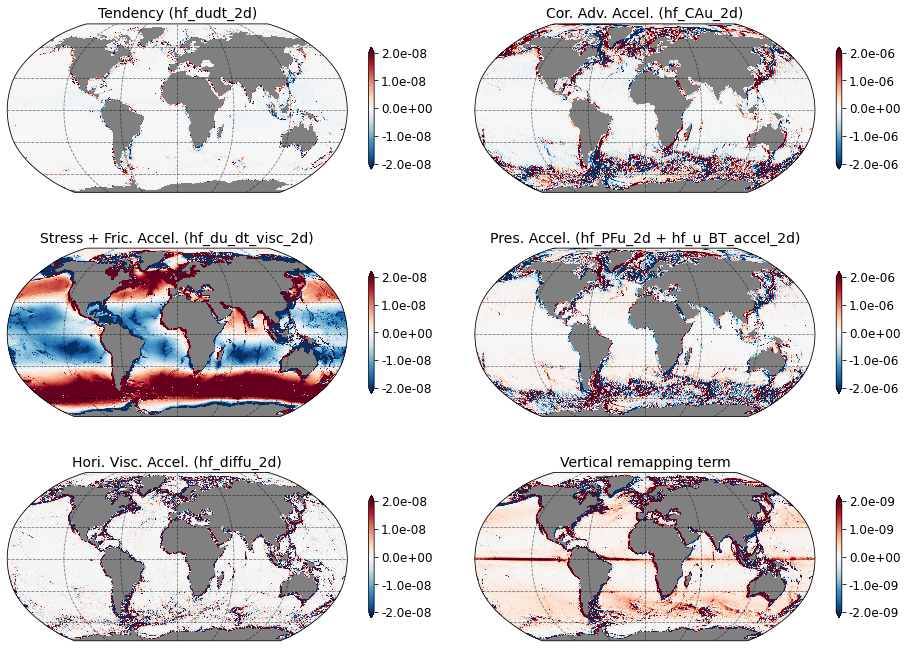

In [9]:
# Zonal Momentum budget (units are in m/s2)
max_r = 0.2e-5

grid = plt.GridSpec(3, 2, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[16,12])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (hf_dudt_2d)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['hf_CAu_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Cor. Adv. Accel. (hf_CAu_2d)')

ax = fig.add_subplot(grid[1, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['hf_PFu_2d']+ds['hf_u_BT_accel_2d'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Pres. Accel. (hf_PFu_2d + hf_u_BT_accel_2d)')
    
ax = fig.add_subplot(grid[1, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['hf_du_dt_visc_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Stress + Fric. Accel. (hf_du_dt_visc_2d)')

ax = fig.add_subplot(grid[2, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['hf_diffu_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Hori. Visc. Accel. (hf_diffu_2d)')

tmp = ds['hf_dudt_2d']-ds['hf_CAu_2d']-ds['hf_PFu_2d']-ds['hf_diffu_2d']-ds['hf_du_dt_visc_2d']-ds['hf_u_BT_accel_2d']
ax = fig.add_subplot(grid[2, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tmp, vmin=-1e-3*max_r, vmax=1e-3*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Vertical remapping term')

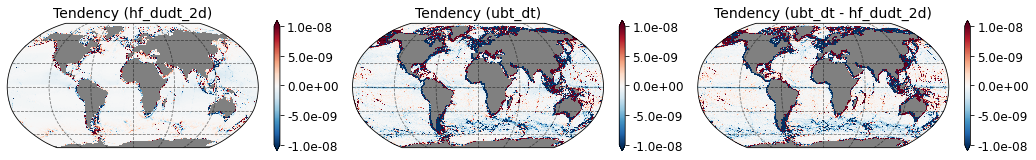

In [10]:
# Difference between barotropic velocity tendency and depth-averaged velocity tendency terms (units are in m/s2)

max_r = 0.1e-5

grid = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (hf_dudt_2d)')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['ubt_dt'] , vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (ubt_dt)')

ax = fig.add_subplot(grid[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['ubt_dt'] - ds['hf_dudt_2d'], vmin=-1e-2*max_r, vmax=1e-2*max_r, vstep=2.e-3*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Tendency (ubt_dt - hf_dudt_2d)')

As shown in first figure, zonal momentum budget closes with monthly-averaged dignostic terms (the same holds for meridional momentum budget). Currently, the contribution from the vertical remapping term is not available as a diagnostic in MOM6 and residual is interpreted as the contribution from the vertical remapping. The vertical remapping term need not be zero in the vertical average and the term is relatively small in comparison to other monthly-averaged diagnostics. Note that time-averaging affects the relative magnitudes of individual budget terms. For example in case of daily-averaged budget terms, the magnitude of the velocity tendency term tends to be relatively larger than the montly-averaged velocity tendency.

In second figure, we compare the depth-averaged velocity tendency (left panel) and barotropic velocity tendency (middle panel) terms. The diagnostics are fairly close, except near the continental boundaries, and the difference (shown in the right panel) is relatively small. The difference of the two represents the contribution from the nonzero thickness tendency term. 

### Identifying the zonal acceleration due to vertical friction, surface wind stress and bottom friction

MOM6 combines contributions from vertical friction, wind stress and bottom friction in a single diagnostic. It is not possbile to isolate contributions from individual components offline in the depth-averaged budgets because these wind stress and friction are applied to selected fluid layers and layer thicknesses vary in time. 

However, the three components can be isolated in the vertically integrated momentum equations as `taux, tauy` (wind stress contribution in Pa) and `taux_bot, tauy_bot` (bottom friction contribution in Pa) are available as diagnostics in MOM6. 

\begin{eqnarray}
\int_z \boldsymbol{F}_x^{{\text{vert frict}}} & = & (\rho_o H) \times \text{hf_du_dt_visc_2d} - \left[ \text{ taux} - \text{taux_bot } \right] \\
\int_z \boldsymbol{F}_y^{{\text{vert frict}}} & = & (\rho_o H) \times \text{hf_dv_dt_visc_2d} - \left[\text{ tauy} - \text{tauy_bot }\right] 
\end{eqnarray}

$\rho_o = 1035.$ kg/m$^3$ is the reference density. Note that $\tau^{\text{bound}}$ in the governing equations is in N/m$^3$ whereas `taux, tauy, taux_bot, tauy_bot` diagnostics are in N/m$^2$. Below, we show the three components from the zonal momentum equation. As seen in the figure below, the surface wind stress contirubiton is much larger than other terms. Ideally, the depth-average of vertical friction term should be zero everywhere because the vertical diffusion must vanish in the vertical integral. However, we observe nonzero values in many places as the method we adopted to compute the vertical friction contribution is not perfect. Nevertheless, $\int_z \boldsymbol{F}_x^{{\text{vert frict}}}$ is much smaller than `taux` and `tauy`.

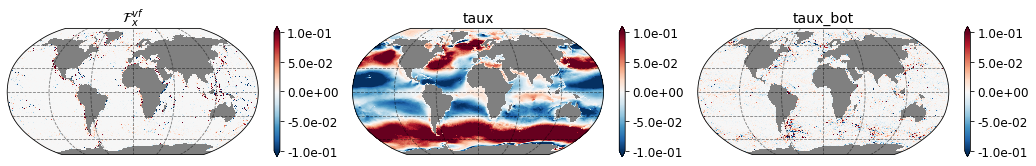

In [4]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

# H should be equal to ocean depth + SSH. For the purpose for demonstration, we use ocean depth only.
H = grid.interp(ds.deptho, 'X',  boundary='fill')

F_vx = H * 1035. * ds['hf_du_dt_visc_2d'] - (ds['taux'] - ds['taux_bot'])

max_r = 0.1

grid = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, F_vx, vmin=-max_r, vmax=max_r, vstep=2.e2*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='$\mathcal{F}_x^{vf}$')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['taux'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='taux')

ax = fig.add_subplot(grid[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, ds['taux_bot'], vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='taux_bot')

## Topographic form stress

In the oceans, momentum input from winds at the surface is expected to be laregly balanced by topographic form stress, especially in the Southern Ocean [Munk and Palmén, 1951](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.2153-3490.1951.tb00776.x), and bottom friction plays a relatively minor role. By integrating the zonal momnetum equation in the vertical, we obtain the expression for topographic form stress $\tau_\text{f}$

\begin{equation}
    \tau_\text{f} = p_b\frac{\partial \eta_b}{\partial x}
\end{equation}

Here, $p_b$ is the pressure at the sea floor and $\eta_b$ is the topographic height. Below, we plot topographic form stress in the $1/4^{\circ}$ global simulation. Before ploting, we applied a roliling window to $\tau_\text{f}$ (20 grid points were chosen arbitrarily) for filtering small-scale variations and clearly show the large-scale structure of topographic form stress.

In [11]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

topo_x = - grid.diff(ds.deptho * ds.dyt, 'X', boundary='fill') / ds.areacello_cu # negative sign in gradient calculation as we are using ocean depth 
tau_f = topo_x * grid.interp(ds.pbo, 'X',  boundary='fill') # first interpolate pbo on u points

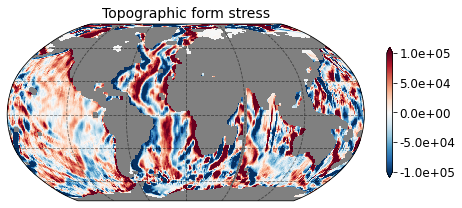

In [14]:
# smooth data to remove small-scale noise
tau_f_smooth = tau_f.rolling(xq = 20, center=True).mean().rolling(yh = 20, center=True).mean()

max_r = 1.e5

grid = plt.GridSpec(1, 1, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[8, 4])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f_smooth, vmin=-max_r, vmax=max_r, vstep=max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topographic form stress')

## Example `diag_table`

```
# MOM6 momentum budget diagnostics
"ocean_monthly", 1, "months",   1, "days", "time"

"ocean_model", "hf_dudt_2d", "hf_dudt_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_dvdt_2d", "hf_dvdt_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "ubt_dt", "ubt_dt", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "vbt_dt", "vbt_dt", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_PFu_2d", "hf_PFu_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_PFv_2d", "hf_PFv_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_CAu_2d", "hf_CAu_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_CAv_2d", "hf_CAv_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_diffu_2d", "hf_diffu_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_diffv_2d", "hf_diffv_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_du_dt_visc_2d", "hf_du_dt_visc_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_dv_dt_visc_2d", "hf_dv_dt_visc_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_gKEu_2d", "hf_gKEu_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_gKEv_2d", "hf_gKEv_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_rvxu_2d", "hf_rvxu_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_rvxv_2d", "hf_rvxv_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_u_BT_accel_2d", "hf_u_BT_accel_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "hf_v_BT_accel_2d", "hf_v_BT_accel_2d", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "pbo", "pbo", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "taux", "taux", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "tauy", "tauy", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "taux_bot", "taux_bot", "ocean_monthly", "all", "mean", "none",1
"ocean_model", "tauy_bot", "tauy_bot", "ocean_monthly", "all", "mean", "none",1
```

In [15]:
ds.close()
client.close()
cluster.close()